In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from src.styles import *
set_styles()

from warnings import filterwarnings
filterwarnings('ignore')

- 106800 marked events
- 17089 events that are at least 50s apart
- 17089 unique eeg_id -- coinside wih distinct events

1950 unique patient_id



In [2]:
df_train = pd.read_csv('data/train.csv')
df_train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


The event for classification happens in the middle 10s of the 50s window.

50s windows start at 'eeg_label_offset_seconds' => if offset1-offset2 for the same eeg_id differ less than 10s => same event, redundant data

treat redundant rows as augmentation?

In [3]:
df_train = df_train.sort_values(['eeg_id', 'eeg_label_offset_seconds'])
dif= df_train['eeg_label_offset_seconds'] - df_train['eeg_label_offset_seconds'].shift(1)
df_distinct = df_train.loc[~((dif > 0) & (dif < 50))]

In [4]:
# for test the eeg records are unique, for train there are redundant entries, drop them
df_first = df_train.groupby('eeg_id').agg('first')
df_first

,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
eeg_id,,,,,,,,,,,,,,
568657,0,0.0,789577333,0,0.0,1825637311,20654,Other,0,0,3,0,2,7
582999,0,0.0,1552638400,0,0.0,1722186807,20230,LPD,0,12,0,1,0,1
642382,0,0.0,14960202,12,1008.0,3254468733,5955,Other,0,0,0,0,0,1
751790,0,0.0,618728447,4,908.0,2898467035,38549,GPD,0,0,1,0,0,0
778705,0,0.0,52296320,0,0.0,3255875127,40955,Other,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4293354003,0,0.0,1188113564,0,0.0,447244163,16610,GRDA,0,0,0,0,1,1
4293843368,0,0.0,1549502620,0,0.0,1618953053,15065,GRDA,0,0,0,0,1,1
4294455489,0,0.0,2105480289,0,0.0,469526364,56,Other,0,0,0,0,0,1


In [5]:
set(df_first.index) - set(df_distinct['eeg_id'])

set()

In [6]:
set(df_distinct['eeg_id']) - set(df_first.index)

set()

In [7]:
df_distinct['patient_id'].nunique()

1950

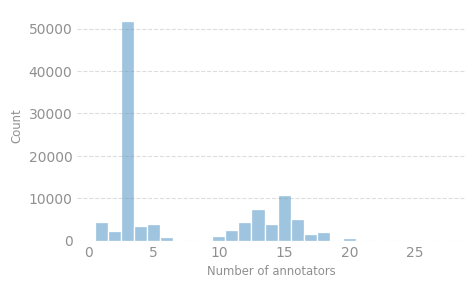

In [8]:
num_annotators = df_train.iloc[:, -6:].sum(axis=1)

_, ax = plt.subplots(figsize=(5, 3))
sns.histplot(num_annotators-0.5, ax=ax, edgecolor='w', binwidth=1)
ax.yaxis.grid(True)
ax.set_xlabel('Number of annotators')
plt.show()

Two clusters of annotated data?

In [9]:
num_annotators_full = df_train.iloc[:, -6:].sum(axis=1)

patients_3 = df_train.loc[num_annotators_full < 9, 'patient_id'].unique()
patients_15 = df_train.loc[num_annotators_full >= 9, 'patient_id'].unique()

len(list(set(patients_15) & set(patients_3)))

907

In [10]:
eeg_3 = df_train.loc[num_annotators_full < 9, 'eeg_id'].unique()
eeg_15 = df_train.loc[num_annotators_full >= 9, 'eeg_id'].unique()

len(list(set(eeg_15) & set(eeg_3)))

750

Some EEG records were processed by both clusters of annotators.

In [11]:
def target_status(row):
    num_annot = row.iloc[-6:].sum()
    if (num_annot < 3):
        return 'weak'
    
    row = row.iloc[-6:] / num_annot
    delta = 2. / num_annot
    if (row.iloc[-6:] == 1).any():
        return 'ideal'
    elif (row['other_vote'] >= (0.5 - delta)) & (row['other_vote'] <= (0.5 + delta)) & (row.iloc[-6:-1] == (1. - row['other_vote'])).any():
        return 'proto'
    elif (row['other_vote'] < delta):
        for i in range(2, 7):
            cur = row.iloc[-i]
            if (cur >= (0.5 - delta)) & (cur <= (0.5 + delta)):
                if ((row.iloc[-6:-i] == (1. - cur)).any()) | ((row.iloc[-i+1:-1] == (1. - cur)).any()):
                    return 'edge'
                
    return 'weak'

In [12]:
df = pd.read_csv('data/train.csv').sort_values(['eeg_id', 'eeg_label_offset_seconds'])
dif = df['eeg_label_offset_seconds'] - df['eeg_label_offset_seconds'].shift(1)
df = df.loc[~((dif > 0) & (dif < 50))].reset_index(drop=True) # use only different events

df_bad_ch = pd.read_csv('data/num_bad_channels.csv')
df.insert(df.shape[1] - 7, 'num_bad_channels', df_bad_ch['num_bad_channels'])

status = df.apply(lambda row: target_status(row), axis=1)
df.insert(df.shape[1] - 7, 'status', status)

df.insert(df.shape[1] - 7, 'num_annotators', df.iloc[:, -6:].sum(axis=1))
for i in range(6): df.iloc[:, -i-1] /= df['num_annotators']
df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,num_bad_channels,status,num_annotators,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,0,0.0,789577333,0,0.0,1825637311,20654,0,weak,12,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,0,0.0,1552638400,0,0.0,1722186807,20230,0,weak,14,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,0,0.0,14960202,12,1008.0,3254468733,5955,1,weak,1,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,0,0.0,618728447,4,908.0,2898467035,38549,0,weak,1,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,0,0.0,52296320,0,0.0,3255875127,40955,2,weak,2,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0.0,1188113564,0,0.0,447244163,16610,0,weak,2,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,0,0.0,1549502620,0,0.0,1618953053,15065,0,weak,2,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,0,0.0,2105480289,0,0.0,469526364,56,0,weak,1,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,0,0.0,657299228,0,0.0,561576493,4312,0,weak,15,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [13]:
df['status'].value_counts()

status
weak     11015
ideal     5361
proto      493
edge       220
Name: count, dtype: int64

In [14]:
def display_distributions(row, ax=None):

    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(5,1.5))

    data1 = row[-6:].values.astype('float32')
    ax.bar(height=data1, x=np.arange(6), width=0.3, label='true')
    ax.set_xticks(np.arange(6), ['seizure','lpd','gpd','lrda','grda','other'])
    ax.yaxis.grid(True)
    ax.set_ylabel('number of votes')

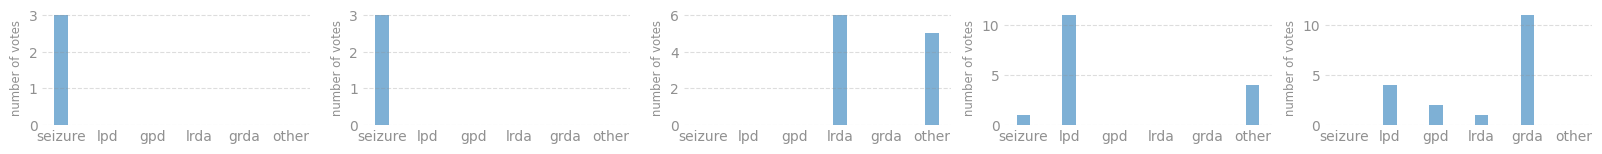

In [15]:
N = 5
_, axes = plt.subplots(ncols=5, nrows=1, figsize=(N*4,1.5))
axes = axes.ravel()

for n, ax in zip(np.random.randint(0, df_train.shape[0] + 1, N), axes):
    display_distributions(df_train.iloc[n], ax)

In [16]:
# for each label count idealized cases

n_cases = []
for col in range(1,7):
    tmp = df.loc[df.iloc[:, -col] == 1]
    n_cases.append(tmp.shape[0])
    print(df.columns[-col].rjust(20), '     ', tmp.shape[0], 'ideal cases')

sum(n_cases)

          other_vote       4208 ideal cases
           grda_vote       1154 ideal cases
           lrda_vote       384 ideal cases
            gpd_vote       806 ideal cases
            lpd_vote       1181 ideal cases
        seizure_vote       2227 ideal cases


9960

about half of the labels are very good

In [17]:
def display_barh(data):
    plt.figure(figsize=(4, len(data)*0.4))

    ax = sns.barplot(data / data.sum(), orient='h', width=0.8)
    ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
    plt.ylabel('target')
    plt.xlabel('')
    ax.xaxis.grid(True)
    plt.tight_layout()
    plt.show()

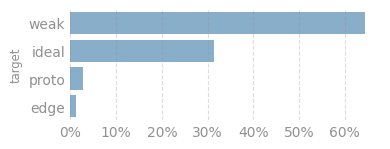

In [18]:
display_barh(df['status'].value_counts())

          other_vote        1505 idealized cases with at least 3 annotators
           grda_vote         855 idealized cases with at least 3 annotators
           lrda_vote         245 idealized cases with at least 3 annotators
            gpd_vote         165 idealized cases with at least 3 annotators
            lpd_vote         502 idealized cases with at least 3 annotators
        seizure_vote        2089 idealized cases with at least 3 annotators


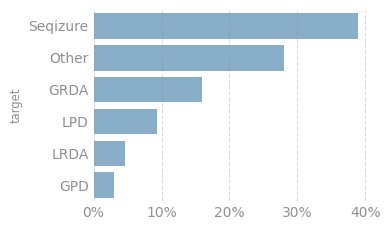

In [19]:
# for each label count idealized cases with many annotators

cases = {}
for col in range(1,7):
    tmp = df.loc[(df.iloc[:, -col] == 1) & (df['status'] == 'ideal')]
    print(df.columns[-col].rjust(20), '     ', str(tmp.shape[0]).rjust(5), 'idealized cases with at least 3 annotators')
    cases[df.columns[-col]] = tmp.shape[0]

display_barh(pd.Series(cases.values(), index=['Other', 'GRDA', 'LRDA', 'GPD', 'LPD', 'Seqizure']).sort_values(ascending=False))